# Predicting Hotel Cancellations

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

March 2022




## Initial Setup

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import statsmodels as sm
from math import ceil
from datetime import timedelta
import os

import graphviz

import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, f_regression


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier

from sklearn.impute import KNNImputer


from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import f1_score

from sklearn.naive_bayes import GaussianNB

In [3]:
## Install: 
## conda install -c conda-forge imbalanced-learn

In [4]:
#import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

In [5]:
from sklearn.manifold import TSNE
import umap
import umap.plot


In [6]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL


In [7]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)


Pandas version  1.3.3
Numpy version  1.20.3
Scipy version  1.7.0
Seaborn version  0.11.2


In [8]:
COLORS = ['#22446d', '#446f8b', '#689ea6', '#94cdbc', '#e6f9af', '#f5b68e', '#eb756f', '#cb3553', '#93003a']

CAT_COLORS = ['#22446D', '#6ABB5D', '#F3E97B', '#FC9E4F', '#AB2346']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#22446d', '#536e88', '#869aa5', '#bcc8c3', '#f3f8e2', '#d7c0a6', '#c38987', '#af5067', '#93003a']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = False
RANDOM_STATE = 9

IMG_PATH = 'imgs/'
DATA_PATH = 'data/'


In [9]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 70

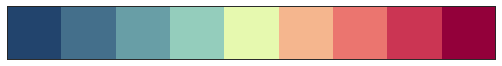

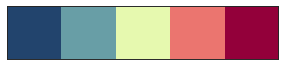

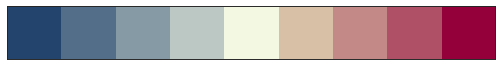

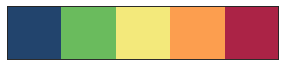

In [10]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

In [11]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight')
        


In [12]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [13]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL ["+ colname + "].")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL ["+ colname + "].")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




In [14]:
df = pd.read_csv('../../source/H2.csv')

df_original = df.copy(deep=True)

df.head(3)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30


## Data Preprocessing

### Convert types

In [15]:
MONTHS = ['January', 'February', 'March', 'April', 'May','June',
          'July','August','September','October','November','December']

MONTH_NUMS = [i+1 for i in range(12)]

df['ArrivalDateMonthNumber'] = df['ArrivalDateMonth'].replace(to_replace=MONTHS, value=MONTH_NUMS)
#df.loc[:,['ArrivalDateMonth','ArrivalDateMonthNumber']]

In [16]:
df['ArrivalDate'] = df['ArrivalDateYear'].astype(str) + '-' + df['ArrivalDateMonthNumber'].astype(str) + '-' + df['ArrivalDateDayOfMonth'].astype(str)
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate'])
# df['ArrivalDate']

In [17]:
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])
# print(df.dtypes)


In [18]:
df['BookingChanges'] = df['BookingChanges'].astype(int)


### Check nulls

In [19]:
df['Company'] = df['Company'].replace('       NULL', np.nan)

In [20]:
df['Company'][0]

nan

In [21]:
df.isna().sum()

IsCanceled                         0
LeadTime                           0
ArrivalDateYear                    0
ArrivalDateMonth                   0
ArrivalDateWeekNumber              0
ArrivalDateDayOfMonth              0
StaysInWeekendNights               0
StaysInWeekNights                  0
Adults                             0
Children                           4
Babies                             0
Meal                               0
Country                           24
MarketSegment                      0
DistributionChannel                0
IsRepeatedGuest                    0
PreviousCancellations              0
PreviousBookingsNotCanceled        0
ReservedRoomType                   0
AssignedRoomType                   0
BookingChanges                     0
DepositType                        0
Agent                              0
Company                        75641
DaysInWaitingList                  0
CustomerType                       0
ADR                                0
R

Drop Company because too many nulls

In [22]:
df.drop(columns=['Company'],inplace=True)

Impute missing values for Country and Children with modes

In [23]:
df['Country'].fillna(value=df['Country'].mode()[0], inplace=True)

In [24]:
df['Children'].fillna(value=df['Children'].mode()[0], inplace=True)
df['Children'] = df['Children'].astype(int)

In [25]:
#df.isna().sum()

### Check duplicates

In [26]:
## duplicates kept
df_hasdups = df.copy()

## duplicated rows
df_dups = df[df.duplicated(keep=False)]

## duplicates removed
df.drop_duplicates(keep='first', inplace=True)

### Separate numeric and non-numeric features

In [27]:
num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
num_feats

['IsCanceled',
 'LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ArrivalDateMonthNumber']

In [28]:
cat_feats = df.columns.drop(num_feats).to_list()
cat_feats

['ArrivalDateMonth',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate',
 'ArrivalDate']

In [29]:
num_feats.remove('IsCanceled')
num_feats.remove('IsRepeatedGuest')
cat_feats.append('IsRepeatedGuest')


In [30]:
num_feats.remove('ArrivalDateYear')
num_feats.remove('ArrivalDateWeekNumber')
num_feats.remove('ArrivalDateDayOfMonth')
num_feats.remove('ArrivalDateMonthNumber')


In [31]:
print(cat_feats)
print('\n\n')
print(num_feats)


['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'CustomerType', 'ReservationStatus', 'ReservationStatusDate', 'ArrivalDate', 'IsRepeatedGuest']



['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests']


# Data Understanding

From the reference paper:
> In hotel industry it is quite common for customers to change their booking׳s attributes, like the number of persons, staying duration, or room type preferences, either at the time of their check-in or during their stay. It is also common for hotels not to know the correct nationality of the customer until the moment of check-in.
> 
> ...
> 
> Analyzing these figures it is possible to verify that, for both of the hotels, the distribution of variables like Adults, Children, StaysInWeekendNights, StaysInWeekNights, Meal, Country and AssignedRoomType is clearly different between non-canceled and canceled bookings.


We remove `Adults`, `Children`, `Meal`, `Country` and `AssignedRoomType`.
We keep `StaysInWeekendNights`, `StaysInWeekNights`. 

We consider it unlikely that having the wrong country or the incorrect number of children
listed is the reason for canceling; however it is possible that schedule changes may be a reason.

In [32]:
num_feats.remove('Adults')
num_feats.remove('Children')
num_feats.remove('Babies')
print(num_feats)

['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests']


In [33]:
cat_feats.remove('Country')
cat_feats.remove('AssignedRoomType')

## Remove ReservationStatusDate because this is a response to IsCanceled, not a predictor
cat_feats.remove('ReservationStatusDate')

## Remove from modeling because this date will never happen again
cat_feats.remove('ArrivalDate')

## Remove because there are too many unique values
cat_feats.remove('Agent')

## Remove because this corresponds to IsCanceled
cat_feats.remove('ReservationStatus')

print(cat_feats)


['ArrivalDateMonth', 'Meal', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'DepositType', 'CustomerType', 'IsRepeatedGuest']


## Time Series Analysis

In [34]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList',
       'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDateMonthNumber', 'ArrivalDate'],
      dtype='object')

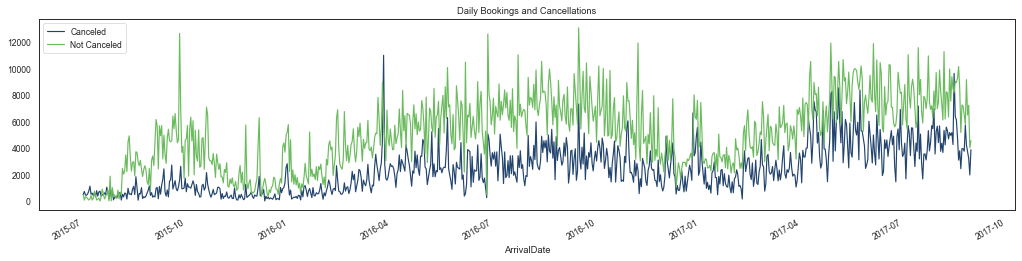

In [35]:
fig, ax = plt.subplots(figsize=(18,4))

df_ts = df.copy()

df_ts['ADR_Diff'] = df_ts['ADR']
df_ts.loc[df_ts['IsCanceled']==True, ['ADR_Diff']] *= 1


df_ts.loc[df['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[0], label='Canceled')

df_ts.loc[df['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[1], label='Not Canceled')


## Plot percent canceled

plt.title("Daily Bookings and Cancellations")

plt.legend()
plt.show()

In [36]:
df_ts.loc[df_ts['ArrivalDate']=='2016-04-01',['ArrivalDate','ADR','ADR_Diff','IsCanceled']].groupby(['IsCanceled']).sum()

,ADR,ADR_Diff
IsCanceled,,
0,4587.76,4587.76
1,2604.71,2604.71


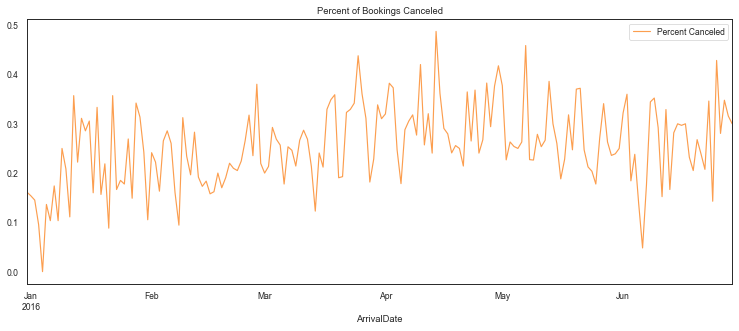

,0,1,total,diff,percentCanceled
ArrivalDate,,,,,
2015-07-01,6.0,6.0,12.0,0.0,0.500000
2015-07-02,1.0,10.0,11.0,-9.0,0.909091
2015-07-03,5.0,6.0,11.0,-1.0,0.545455
2015-07-04,4.0,6.0,10.0,-2.0,0.600000
2015-07-05,0.0,8.0,8.0,-8.0,1.000000
...,...,...,...,...,...
2017-08-27,76.0,28.0,104.0,48.0,0.269231
2017-08-28,50.0,27.0,77.0,23.0,0.350649
2017-08-29,56.0,21.0,77.0,35.0,0.272727


In [37]:
df_ts2 = df.groupby(['ArrivalDate','IsCanceled']).size().unstack()
df_ts2 = df_ts2.T.reset_index(drop=True).T.replace(np.nan,0)
df_ts2['total'] = df_ts2[0]+df_ts2[1]
df_ts2['diff'] = df_ts2[0]-df_ts2[1]

df_ts2['percentCanceled'] = df_ts2[1]/df_ts2['total']

fig, ax = plt.subplots(figsize=(13,5))

df_ts2[183:365]['percentCanceled'].plot(ax=ax, color=CAT_COLORS[3], label='Percent Canceled')

plt.title('Percent of Bookings Canceled')

plt.legend()
plt.show()

df_ts2

In [38]:
endog = df_ts2['percentCanceled']
endog.index = pd.period_range('2015-07-01','2017-08-31',freq='D')

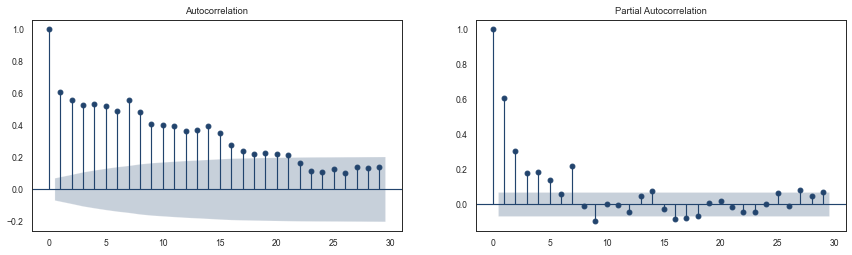

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

sm.graphics.tsa.plot_acf(endog, ax=axes[0])
sm.graphics.tsa.plot_pacf(endog, method="ywm", ax=axes[1])

plt.show()

AR(7) Model: seasonality of 7 days

## Summary of features

In [40]:
num_feats # numeric features
cat_feats # non-numeric features

all_cols = df.columns # all available columns

# other features not used in modeling
not_used_feats = [i for i in all_cols if i not in num_feats]
not_used_feats = [i for i in not_used_feats if i not in cat_feats]

In [41]:
## Clean up category values to remove trailing whitespace
for cf in cat_feats:
    if df[cf].dtype == 'object' :
        df[cf] = df[cf].str.strip()

# Data Preparation

## Split Validation Data

In [42]:
df = df.sort_values(by='ArrivalDate')


In [43]:
df.head(3)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate
0,0,6,2015,July,27,1,0,2,1,0,...,6,0,Transient,0.0,0,0,Check-Out,2015-07-03,7,2015-07-01
34906,1,257,2015,July,27,1,0,2,2,0,...,6,0,Transient,101.5,0,0,Canceled,2015-06-16,7,2015-07-01
34939,1,181,2015,July,27,1,1,4,2,0,...,9,0,Transient,76.5,0,0,Canceled,2015-06-17,7,2015-07-01


In [44]:
df.tail(3)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate
79253,0,211,2017,August,35,31,0,3,3,0,...,9,0,Transient,162.00,0,1,Check-Out,2017-09-03,8,2017-08-31
33649,1,261,2017,August,35,31,2,3,2,0,...,9,0,Transient,99.00,0,1,Canceled,2017-05-05,8,2017-08-31
33641,1,75,2017,August,35,31,0,3,3,0,...,9,0,Transient,193.33,0,0,Canceled,2017-06-29,8,2017-08-31


In [45]:
val_start_date = '2017-01-01'

In [46]:
## Use 2017 data as out of sample validation
## Train-test split:
df_tt = df.loc[df['ArrivalDate'] < val_start_date,: ]
#df_tt.drop_duplicates(keep='first', inplace=True)

## Validation split:
df_vl = df.loc[df['ArrivalDate'] >= val_start_date,: ]

In [47]:
def plot_labels(df, labels, title='Data Visualization', label_map=None):    
    l = labels
    lmap = {}
    
    if label_map:
        l2 = labels.copy()
        for i in range(len(label_map)):
            lmap[label_map[i]] = i
        l = l2.replace(lmap)
        
    fig, ax = plt.subplots(figsize=(10,10))

    scatter = ax.scatter(x=df[0], y=df[1], c=l, cmap=CAT_CMAP,\
               s=2, marker="o", alpha=.5, label='Final Clusters')

    ncol = len(labels.unique().tolist())
    ncol = round(ncol/2) + 1 if ncol > 7 else ncol
    if label_map == None:
        legend1 = ax.legend(*scatter.legend_elements(),
                        bbox_to_anchor=(.5,1,.5,1), loc="lower left", frameon=False,
                        mode='expand', borderaxespad=0, ncol=ncol,
                       )


    ax.set_xticklabels('')
    ax.set_yticklabels('')
    plt.title(title, loc='left')
    
    if SAVE_PLOTS:
        save_fig(title, fig)

    plt.show()

## Generate Oversample Points (SMOTENC)

In [48]:
df_tt['ArrivalDateInt'] = df_tt['ArrivalDate']
df_tt['ArrivalDateInt'] = df_tt['ArrivalDateInt'].apply(lambda x: x.value)
df_tt['ArrivalDateInt'] = df_tt['ArrivalDateInt']/10**9
df_tt['ArrivalDateInt'] = df_tt['ArrivalDateInt'].astype(int)
smote_feats = num_feats+['ArrivalDateInt']


In [49]:
cat_feats_smote = cat_feats.copy()
cat_feats_smote.remove('ArrivalDateMonth')


cat_feats_smote

['Meal',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'DepositType',
 'CustomerType',
 'IsRepeatedGuest']

In [50]:
## Scale before SMOTE-ing
scaler_tt    = StandardScaler().fit(df_tt[num_feats])
transformed_df_tt = scaler_tt.transform(df_tt[num_feats])

df_tt_scaled = df_tt.copy()
df_tt_scaled[num_feats] = transformed_df_tt

In [51]:
smote_cats_i = [i+len(smote_feats) for i in range(len(cat_feats_smote))]

oversample_nc = SMOTENC(random_state=RANDOM_STATE, categorical_features=smote_cats_i)
X2, y2 = oversample_nc.fit_resample(df_tt_scaled[smote_feats+cat_feats_smote], df_tt_scaled['IsCanceled'])


In [52]:

X2['ArrivalDate'] = X2['ArrivalDateInt'] * 10**9
X2['ArrivalDate'] = X2['ArrivalDate'].apply(pd.Timestamp)
X2['ArrivalDate'] = pd.to_datetime(X2['ArrivalDate']).dt.date
X2.drop(columns=['ArrivalDateInt'], inplace=True)

df_smote_scaled = pd.concat([X2,y2], axis=1)


In [53]:
## Unscale after SMOTE-ing
df_smote_invscaled = df_smote_scaled.copy()
df_smote_invscaled[num_feats] = scaler_tt.inverse_transform(df_smote_scaled[num_feats])

In [54]:
df_smotenc = df_smote_invscaled.copy()
df_smotenc['BookingChanges'] = df_smotenc['BookingChanges'].astype(int)
df_smotenc['PreviousCancellations'] = df_smotenc['PreviousCancellations'].astype(int)
df_smotenc['PreviousBookingsNotCanceled'] = df_smotenc['PreviousBookingsNotCanceled'].astype(int)
df_smotenc['TotalOfSpecialRequests'] = df_smotenc['TotalOfSpecialRequests'].astype(int)
df_smotenc['RequiredCarParkingSpaces'] = df_smotenc['RequiredCarParkingSpaces'].astype(int)
df_smotenc['DaysInWaitingList'] = df_smotenc['DaysInWaitingList'].astype(int)
df_smotenc['StaysInWeekendNights'] = df_smotenc['StaysInWeekendNights'].astype(int)
df_smotenc['StaysInWeekNights'] = df_smotenc['StaysInWeekNights'].astype(int)
df_smotenc['LeadTime'] = df_smotenc['LeadTime'].astype(int)

## Because of the scaling roundtrip 
## some rounding issues lead to very small negative number (ie -1.421085e-14)
df_smotenc['ADR'] = df_smotenc['ADR'].round(3).abs()

In [55]:

smotenc_scaler = StandardScaler().fit(df_smotenc[num_feats])
scaled_smotenc = smotenc_scaler.transform(df_smotenc[num_feats])

### Visualize oversampled data (using smotenc)

In [56]:
## Uncomment to plot; Commented to save run time

#umap_data = umap.UMAP(random_state=RANDOM_STATE, metric='euclidean', min_dist=1, n_neighbors=150, n_components=2)\
#                    .fit_transform(scaled_smotenc)
#umap_data_df = pd.DataFrame(umap_data)

In [57]:
## Uncomment to plot; Commented to save run time

#umap_smotenc = umap.UMAP(random_state=RANDOM_STATE, metric='euclidean', min_dist=1, n_neighbors=150, n_components=2)\
#                    .fit_transform(scaled_smotenc)
#umap_smotenc_df = pd.DataFrame(umap_smotenc)


In [58]:
## Uncomment to plot; Commented to save run time

#plot_labels(umap_data_df, df_tt['IsCanceled'], 'UMAP Visualization After Oversampling')

In [59]:
## Uncomment to plot; Commented to save run time

#plot_labels(umap_smotenc_df, df_smotenc['IsCanceled'], 'UMAP Visualization After Oversampling')

In [60]:
print(str(len(df_smotenc) - len(df_tt)), 'extra points generated')

14888 extra points generated


In [61]:
df_smotenc.describe()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,IsRepeatedGuest,IsCanceled
count,48196.000000,48196.000000,48196.000000,48196.000000,48196.000000,48196.000000,48196.000000,48196.000000,48196.000000,48196.000000,48196.000000,48196.000000
mean,74.499896,0.830359,2.224002,0.045875,0.132293,0.193211,1.373931,106.040505,0.028592,0.537804,0.023550,0.500000
std,74.489268,0.900266,1.626575,0.397408,1.589939,0.625575,13.467403,48.147635,0.167155,0.754144,0.151643,0.500005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,80.785750,0.000000,0.000000,0.000000,0.000000
50%,53.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,101.150000,0.000000,0.000000,0.000000,0.500000
75%,110.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,126.900000,0.000000,1.000000,0.000000,1.000000
max,626.000000,16.000000,41.000000,21.000000,58.000000,21.000000,391.000000,5400.000000,3.000000,5.000000,1.000000,1.000000


In [62]:
df_smotenc['ADR'].describe()

count    48196.000000
mean       106.040505
std         48.147635
min          0.000000
25%         80.785750
50%        101.150000
75%        126.900000
max       5400.000000
Name: ADR, dtype: float64

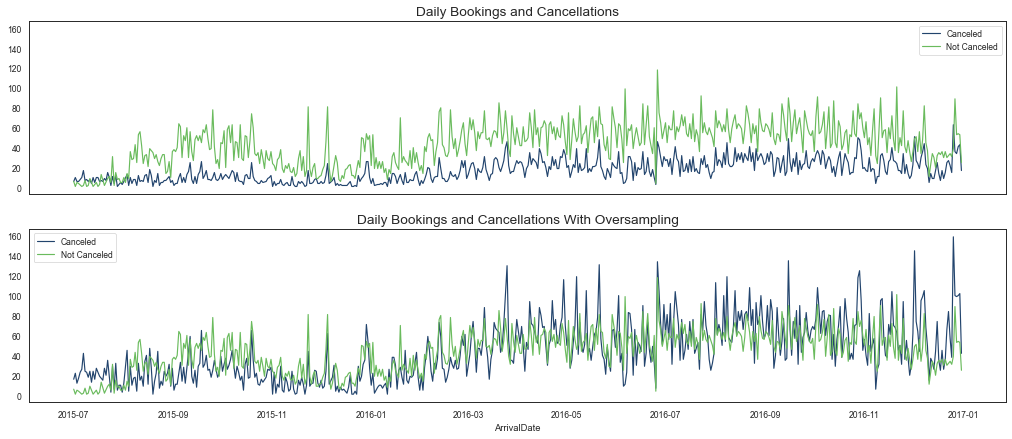

In [63]:
######### Plot before oversampling

fig, ax = plt.subplots(2,1, figsize=(18,8), sharex=True, sharey=True)

df_tt_agg = df_tt.copy()

df_tt_agg['ADR_Diff'] = df_tt_agg['ADR']
df_tt_agg.loc[df_tt_agg['IsCanceled']==True, ['ADR_Diff']] *= 1


df_tt_agg.loc[df_tt_agg['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .count()['ADR'].plot(ax=ax[0], color=CAT_COLORS[0], label='Canceled')

df_tt_agg.loc[df_tt_agg['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .count()['ADR'].plot(ax=ax[0], color=CAT_COLORS[1], label='Not Canceled')

######### Plot oversampled data

df_tt_agg2 = df_smotenc.copy()

df_tt_agg2.loc[df_tt_agg2['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .count()['ADR'].plot(ax=ax[1], color=CAT_COLORS[0], label='Canceled')


df_tt_agg2.loc[df_tt_agg2['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .count()['ADR'].plot(ax=ax[1], color=CAT_COLORS[1], label='Not Canceled')


ax[0].set_title("Daily Bookings and Cancellations", fontsize=14)
ax[1].set_title("Daily Bookings and Cancellations With Oversampling", fontsize=14)

ax[0].legend()
ax[1].legend()

save_fig('Daily Bookings Before and After Oversampling', fig)
plt.show()

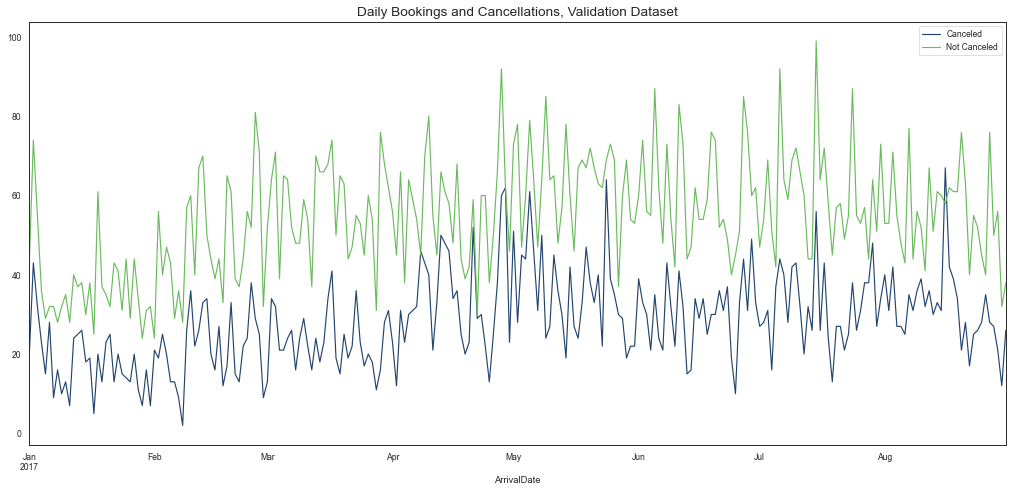

In [64]:
######### Plot before oversampling

fig, ax = plt.subplots(figsize=(18,8), sharex=True, sharey=True)

df_tt_agg = df_vl.copy()

df_tt_agg['ADR_Diff'] = df_tt_agg['ADR']
df_tt_agg.loc[df_tt_agg['IsCanceled']==True, ['ADR_Diff']] *= 1


df_tt_agg.loc[df_tt_agg['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .count()['ADR'].plot(ax=ax, color=CAT_COLORS[0], label='Canceled')

df_tt_agg.loc[df_tt_agg['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .count()['ADR'].plot(ax=ax, color=CAT_COLORS[1], label='Not Canceled')


ax.set_title("Daily Bookings and Cancellations, Validation Dataset", fontsize=14)

ax.legend()


save_fig('Daily Bookings Before and After Oversampling', fig)
plt.show()

## Summary of variables

In [65]:
## Train set with oversampling using SMOTENC
X_train = df_smotenc.drop(columns=['IsCanceled'])
y_train = df_smotenc.loc[:,['IsCanceled']]

## df with X2+y
#df_smotenc

In [66]:
## Validation set without oversampling
X_val = df_vl.drop(columns=['IsCanceled'])
y_val = df_vl['IsCanceled']

In [67]:
X_train.columns

Index(['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'BookingChanges', 'DaysInWaitingList', 'ADR',
       'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', 'Meal',
       'MarketSegment', 'DistributionChannel', 'ReservedRoomType',
       'DepositType', 'CustomerType', 'IsRepeatedGuest', 'ArrivalDate'],
      dtype='object')

In [68]:
## Cat feats
cat_feats_smote

## Num feats
num_feats

['LeadTime',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests']

## Feature Engineering

In [69]:

total_unique_cats = 0
for cf in cat_feats:
    total_unique_cats += len(df[cf].unique())
    print(len(df[cf].unique()), '\t', cf)
print(total_unique_cats, '\t', 'Total')



12 	 ArrivalDateMonth
4 	 Meal
8 	 MarketSegment
5 	 DistributionChannel
8 	 ReservedRoomType
3 	 DepositType
4 	 CustomerType
2 	 IsRepeatedGuest
46 	 Total


Return removed date-related features

In [70]:
## From https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'


In [71]:
X_train['ArrivalDateMonth']       = pd.to_datetime(X_train['ArrivalDate']).dt.month_name()
X_train['ArrivalDateYear']        = pd.to_datetime(X_train['ArrivalDate']).dt.year
X_train['ArrivalDateWeekNumber']  = pd.to_datetime(X_train['ArrivalDate']).dt.week
X_train['ArrivalDateDayOfMonth']  = pd.to_datetime(X_train['ArrivalDate']).dt.day
X_train['ArrivalDateMonthNumber'] = pd.to_datetime(X_train['ArrivalDate']).dt.month
X_train['ArrivalDayOfWeek']       = pd.to_datetime(X_train['ArrivalDate']).dt.dayofweek
X_train['Season']                 = pd.to_datetime(X_train['ArrivalDate']).map(season_of_date)

X_val['Season']                   = pd.to_datetime(X_val['ArrivalDate']).map(season_of_date)
X_val['ArrivalDayOfWeek']         = pd.to_datetime(X_val['ArrivalDate']).dt.dayofweek


#X_train

df_smotenc['ArrivalDateMonth']       = pd.to_datetime(df_smotenc['ArrivalDate']).dt.month_name()
df_smotenc['ArrivalDateYear']        = pd.to_datetime(df_smotenc['ArrivalDate']).dt.year
df_smotenc['ArrivalDateWeekNumber']  = pd.to_datetime(df_smotenc['ArrivalDate']).dt.week
df_smotenc['ArrivalDateDayOfMonth']  = pd.to_datetime(df_smotenc['ArrivalDate']).dt.day
df_smotenc['ArrivalDateMonthNumber'] = pd.to_datetime(df_smotenc['ArrivalDate']).dt.month
df_smotenc['ArrivalDayOfWeek']       = pd.to_datetime(df_smotenc['ArrivalDate']).dt.dayofweek
df_smotenc['Season']                 = pd.to_datetime(df_smotenc['ArrivalDate']).map(season_of_date)

#df_smotenc



In [72]:
cat_feats.append('ArrivalDateMonth')
num_feats.append('ArrivalDateYear')
num_feats.append('ArrivalDateWeekNumber')
num_feats.append('ArrivalDateDayOfMonth')
num_feats.append('ArrivalDateMonthNumber')
num_feats.append('ArrivalDayOfWeek')
cat_feats_smote.append('Season')


#### Inspect variables: Check histograms

In [73]:
## Function to plot histograms of numeric features for specified dataframe, divided by target variable
def plot_histograms_boxplots_target(df, features, target, rows=4, title = "Histograms of Numeric Variables with Target"):
    if SHOW_PLOTS:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        
        feats = df[features].select_dtypes(include=[np.number]).columns.tolist()
        subfigs = fig.subfigures(rows, ceil(len(feats) / rows))
        
        for subf, feat in zip(subfigs.flatten(), feats):
            axs = subf.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})
        
            df.pivot(columns=target)[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=CAT_COLORS[0:2])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1)
        
            sns.boxplot(x=df.loc[df[target]==0,feat], ax=axs[1], color=CAT_COLORS[0], fliersize=2)
            axs[1].set_xlabel(None)
        
            sns.boxplot(x=df.loc[df[target]==1,feat], ax=axs[2], color=CAT_COLORS[1], fliersize=2)
            axs[2].set_xlabel(None)
        
            subf.suptitle(None)

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

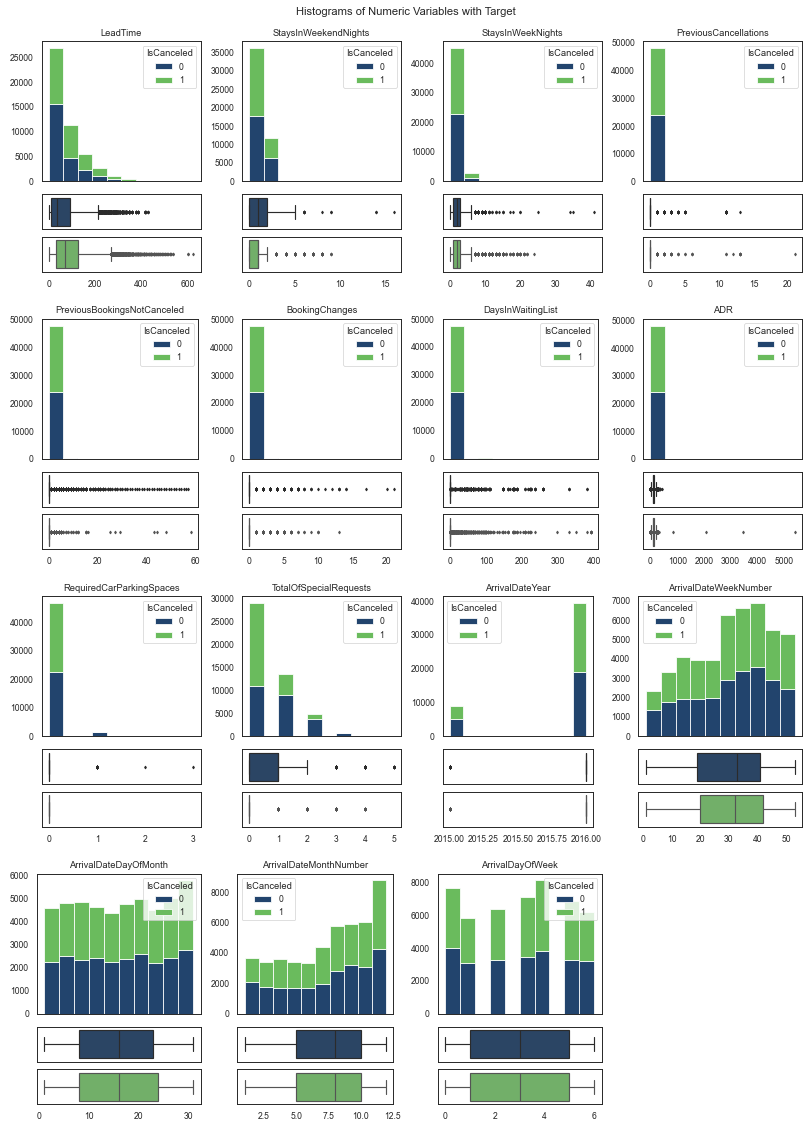

In [74]:
plot_histograms_boxplots_target(df_smotenc, num_feats, 'IsCanceled', rows=4)

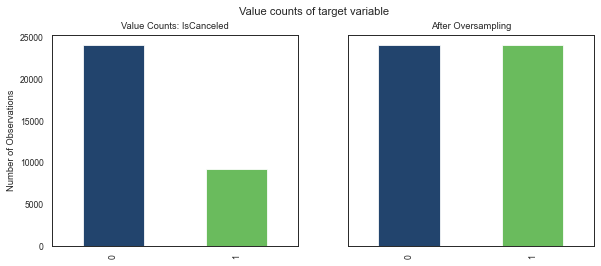

In [75]:
fig, ax = plt.subplots(1,2,figsize=(10,4), sharey=True)

df.loc[df['ArrivalDate']<val_start_date,:].groupby(['IsCanceled']).size()\
        .plot(kind="bar", stacked=False, color=CAT_COLORS[0:2], ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel('Number of Observations')
ax[0].set_title('Value Counts: IsCanceled')

df_smotenc.groupby(['IsCanceled']).size()\
        .plot(kind="bar", stacked=False, color=CAT_COLORS[0:2], ax=ax[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel('Number of Observations')
ax[1].set_title('After Oversampling')

fig.suptitle('Value counts of target variable')
plt.show()

In [76]:
## Function to plot histograms of cat features for specified dataframe
def plot_cat_counts(df, features, target, rows=6, title = "Count Distributions of Categorical Variables"):
    if SHOW_PLOTS:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows), wspace=0.07, hspace=0.1)
        c = CAT_COLORS[0:2]
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(1, 2, sharey=True) #, gridspec_kw={'width_ratios': [4, 1,1]})
 
            df1 = df.groupby([feat,target]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=axs[0], color=c)

            df2 = df.groupby([feat,target]).size().unstack(1)
            df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=axs[1], color=c)
            
            subf.suptitle(feat)
            

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

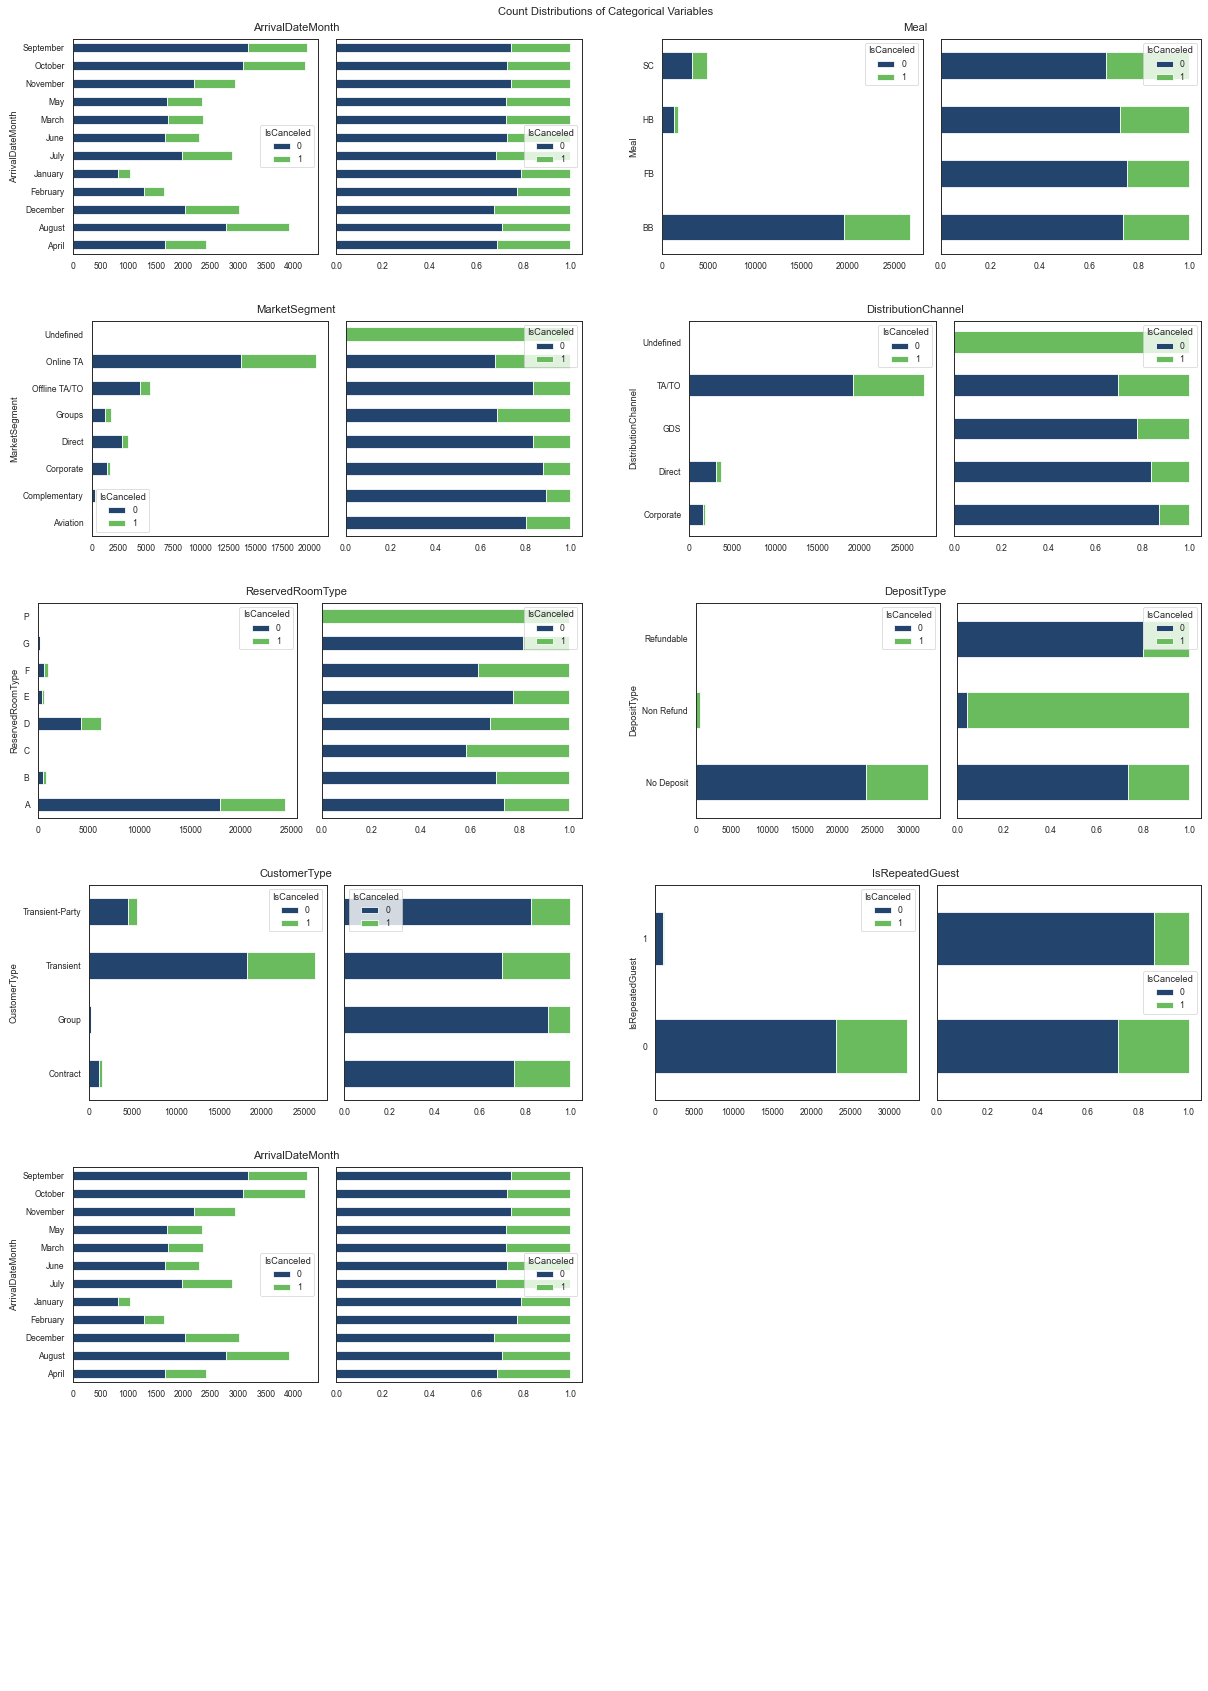

In [77]:
plot_cat_counts(df.loc[df['ArrivalDate']<val_start_date,:], cat_feats, 'IsCanceled', rows = 6)

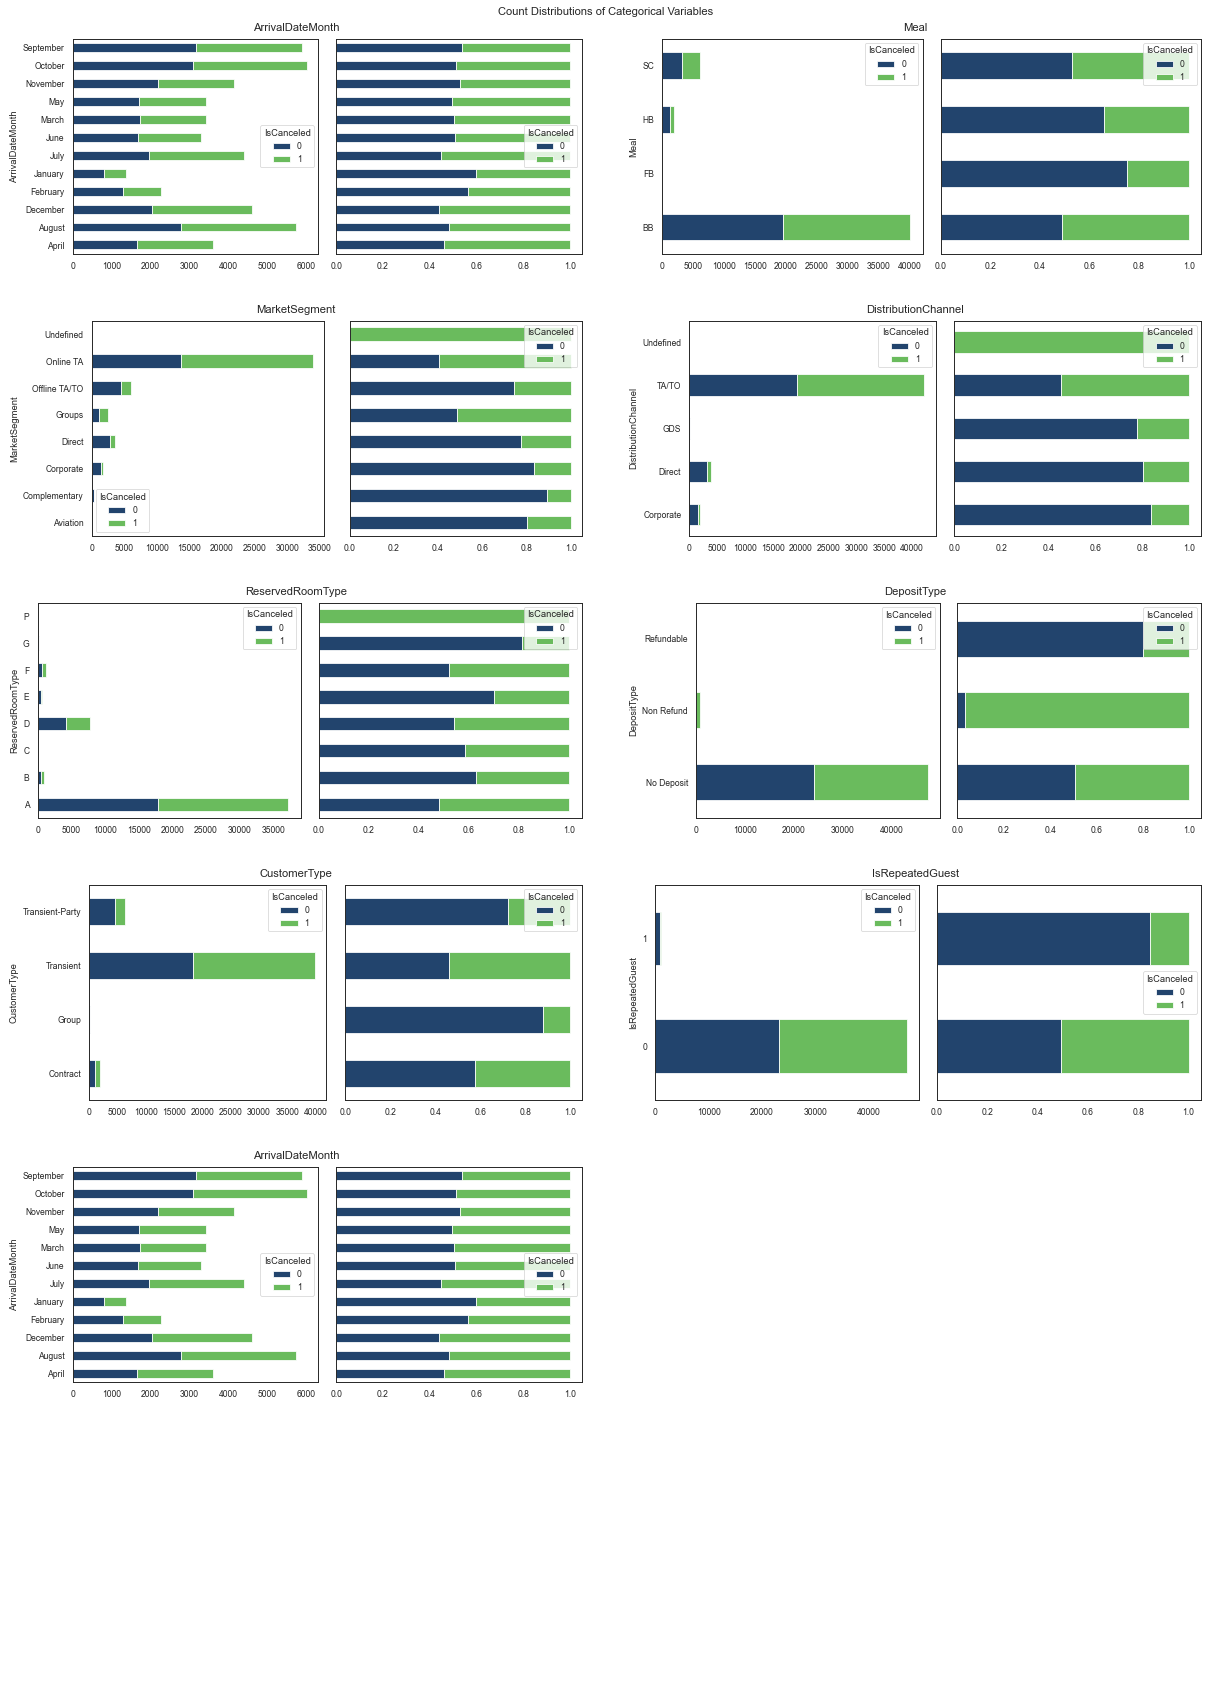

In [78]:
plot_cat_counts(df_smotenc, cat_feats, 'IsCanceled', rows = 6)

In [79]:
# aggregated and shape data

def show_barplot_compare(df, g1, g2) :
    if show_plots:
        
        df = df.sort_values(by=g2,ascending=False)
    
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(23,23))
 
        df1 = df.groupby([g1,g2]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=ax[0], color=CONTRAST_COLORS)

        # aggregated and shape data
        df2 = df.groupby([g1,g2]).size().unstack(1)
        df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=ax[1], color=CONTRAST_COLORS)
    
        plt.show()
        if SAVE_PLOTS:
            save_fig('Bar plot '+ g1 + ' ' + g2, fig)
            

In [80]:
def absolute_relative_histoplot(df, feat, target, title='Absolute and Relative Distributions of Canceled Status by Country', figsize=(21,28)):
    df_ar = df.groupby([feat,target]).size().unstack()
    df_ar = df_ar.T.reset_index(drop=True).T.replace(np.nan,0)
    df_ar['total'] = df_ar[0]+df_ar[1]
    df_ar.sort_values(by='total', inplace=True)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
    df_ar[target] = df_ar[1]
    not_t = 'Not ' + target
    df_ar[not_t] = df_ar[0]

    df_ar.loc[:,[not_t, target]]\
                     .plot(kind="barh", width=1, stacked=True, ax=ax[1], color=CAT_COLORS)
    ax[1].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[1].set_title('Absolute Distribution', loc='left', fontsize=18)


    df_cc2 = df_ar.loc[:,[not_t, target]].div(df_ar['total'], axis=0)\
                    .plot(kind="barh", width=1, stacked=True, ax=ax[0], color=CAT_COLORS)
    ax[0].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[0].set_title('Relative Distribution', loc='left', fontsize=18)

    
    ax[0].yaxis.set_label_position("right")
    ax[0].yaxis.tick_right()
    ax[0].set_ylabel(None)
    ax[1].set_ylabel(None)

    
    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()
    

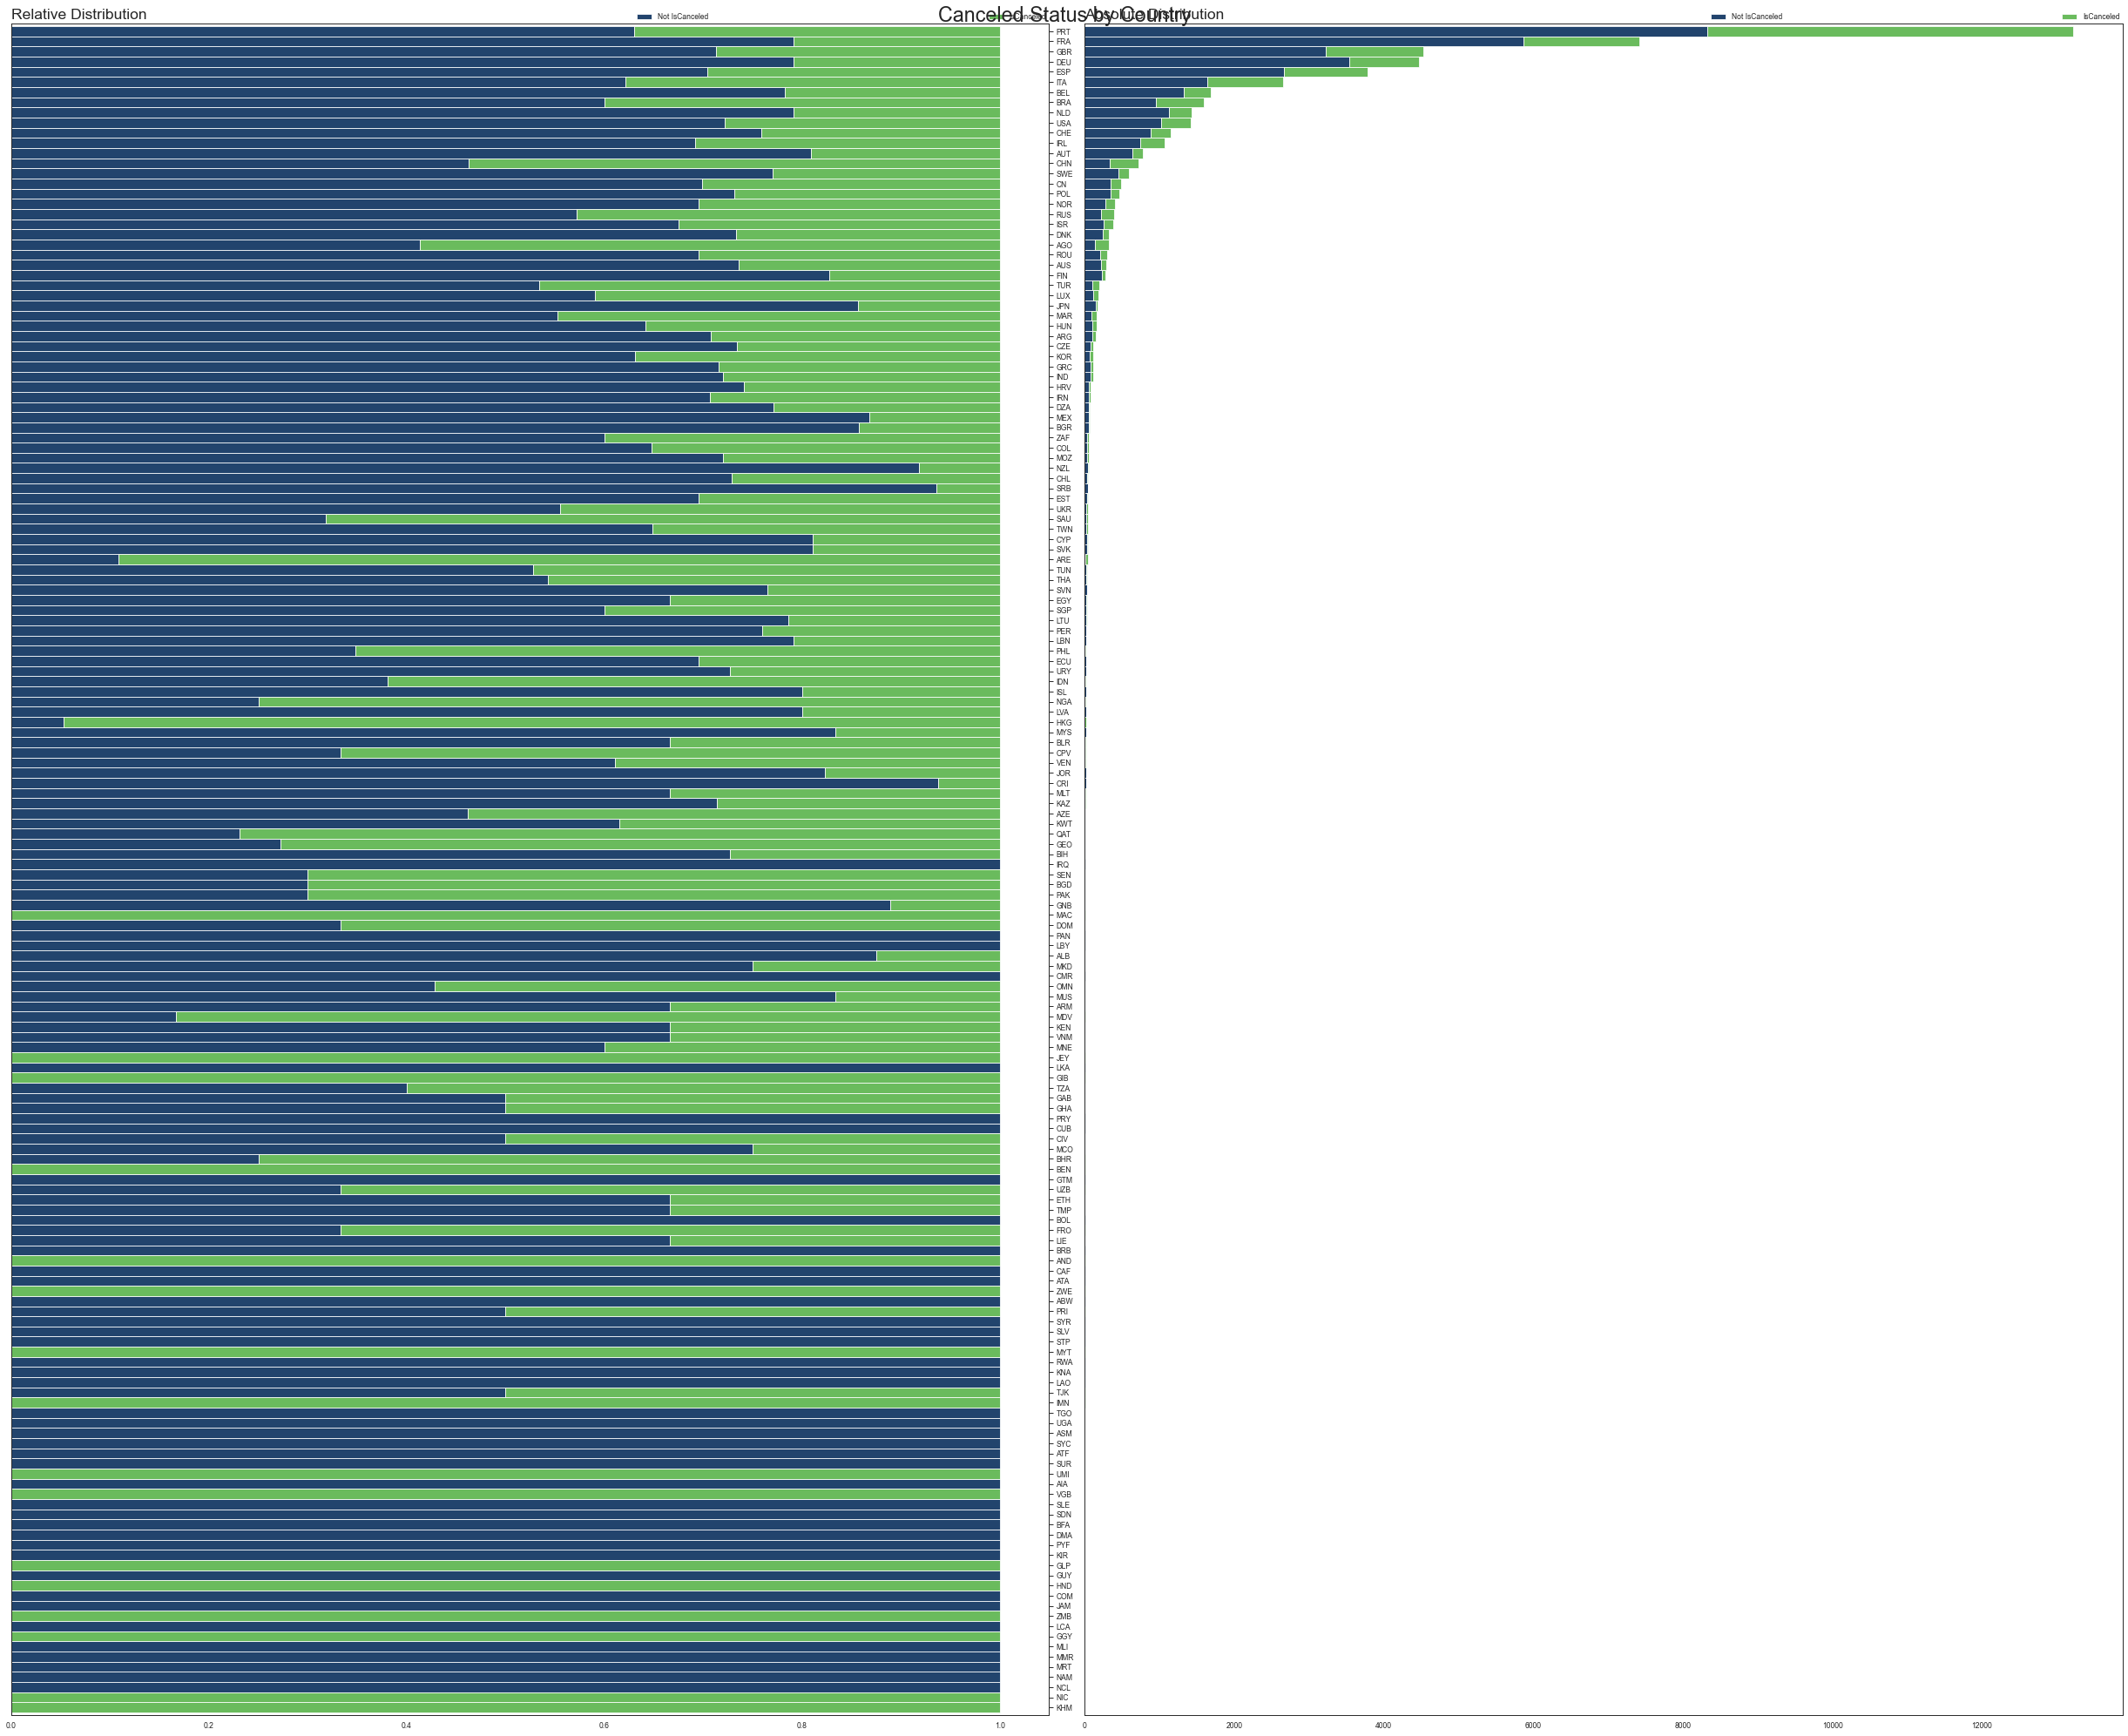

In [81]:
absolute_relative_histoplot(df, 'Country', 'IsCanceled', title='Canceled Status by Country', figsize=(35,29))


### Encoding Selected Cat Features

In [82]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_e_feat = ohe.fit_transform(X_train[cat_feats_smote])
ohe_e_feat_names = ohe.get_feature_names()
cat_feat_ohe = ohe.get_feature_names().tolist()

In [83]:
cat_feat_ohe

['x0_BB',
 'x0_FB',
 'x0_HB',
 'x0_SC',
 'x1_Aviation',
 'x1_Complementary',
 'x1_Corporate',
 'x1_Direct',
 'x1_Groups',
 'x1_Offline TA/TO',
 'x1_Online TA',
 'x1_Undefined',
 'x2_Corporate',
 'x2_Direct',
 'x2_GDS',
 'x2_TA/TO',
 'x2_Undefined',
 'x3_A',
 'x3_B',
 'x3_C',
 'x3_D',
 'x3_E',
 'x3_F',
 'x3_G',
 'x3_P',
 'x4_No Deposit',
 'x4_Non Refund',
 'x4_Refundable',
 'x5_Contract',
 'x5_Group',
 'x5_Transient',
 'x5_Transient-Party',
 'x6_0',
 'x6_1',
 'x7_autumn',
 'x7_spring',
 'x7_summer',
 'x7_winter']

In [84]:
ohe_df = pd.DataFrame(ohe_e_feat, index=X_train.index, columns=ohe_e_feat_names)
ohe_df.head(5)

,x0_BB,x0_FB,x0_HB,x0_SC,x1_Aviation,x1_Complementary,x1_Corporate,x1_Direct,x1_Groups,x1_Offline TA/TO,...,x5_Contract,x5_Group,x5_Transient,x5_Transient-Party,x6_0,x6_1,x7_autumn,x7_spring,x7_summer,x7_winter
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [85]:
df_ohe = pd.concat([X_train, ohe_df], axis=1)

In [86]:
X_train = df_ohe
X_train.head(3)

,LeadTime,StaysInWeekendNights,StaysInWeekNights,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,...,x5_Contract,x5_Group,x5_Transient,x5_Transient-Party,x6_0,x6_1,x7_autumn,x7_spring,x7_summer,x7_winter
0,5,0,2,0,0,0,0,0.0,0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,257,0,2,1,0,0,0,101.5,0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,181,1,4,1,0,0,0,76.5,0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


#### Transform Categorical Validation data

In [87]:
ohe_e_feat_v = ohe.transform(X_val[cat_feats_smote])
ohe_df_v = pd.DataFrame(ohe_e_feat_v, index=X_val.index, columns=ohe_e_feat_names)
X_val = pd.concat([X_val, ohe_df_v], axis=1)


# Feature Selection

## Check numeric features

### Correlations

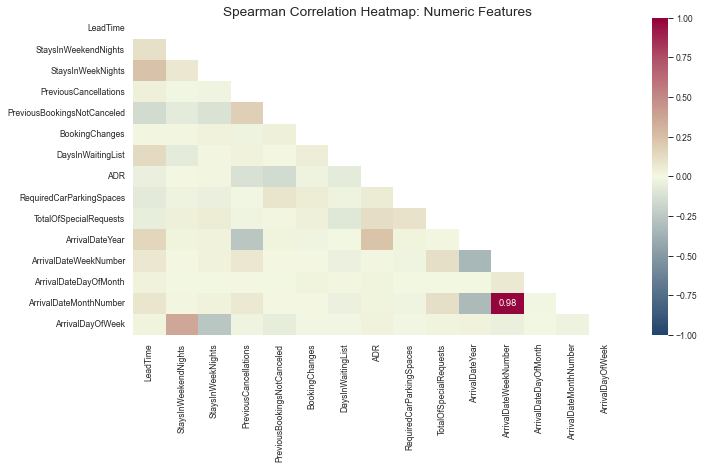

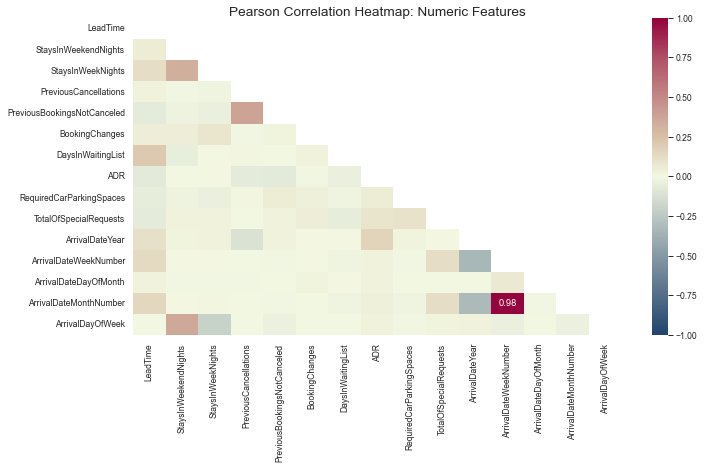

In [88]:
def make_corr_heatmap(df, method, title="Triangle Correlation Heatmap"):
    l = len(df.columns.tolist())
    fig, ax = plt.subplots(figsize=(.75*l, .4*l))
    mask = np.triu(np.ones_like(df.corr(method=method), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=method), mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f' ,cmap=DIV_CMAP)
    heatmap.set_title(title, fontdict={'fontsize':14}, pad=2);
    for t in ax.texts:
        if float(t.get_text())>=0.4:
            t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
        else:
            t.set_text("")
    save_fig(title, fig)
    plt.show()
    
make_corr_heatmap(X_train[num_feats], 'spearman', title="Spearman Correlation Heatmap: Numeric Features")
make_corr_heatmap(X_train[num_feats], 'pearson', title="Pearson Correlation Heatmap: Numeric Features")


In [89]:
## Remove MonthNumber because WeekNumber is more granular
cat_feats.remove('ArrivalDateMonth')
num_feats.remove('ArrivalDateMonthNumber')

### Pair plots

In [90]:
## Uncomment to plot; commented to save run time
#sns.pairplot(df_smotenc[num_feats+['IsCanceled']].sample(500), hue='IsCanceled', palette=CAT_COLORS[0:2])

#g = sns.PairGrid(df_smotenc[num_feats+['IsCanceled']].sample(500), 
#                 diag_sharey=False, hue='IsCanceled', palette=CAT_COLORS[0:2],
#                 )
#g.map_lower(sns.scatterplot, alpha=.5)
#g.map_upper(sns.histplot, alpha=1)
#g.map_diag(sns.kdeplot)



### SelectKBest

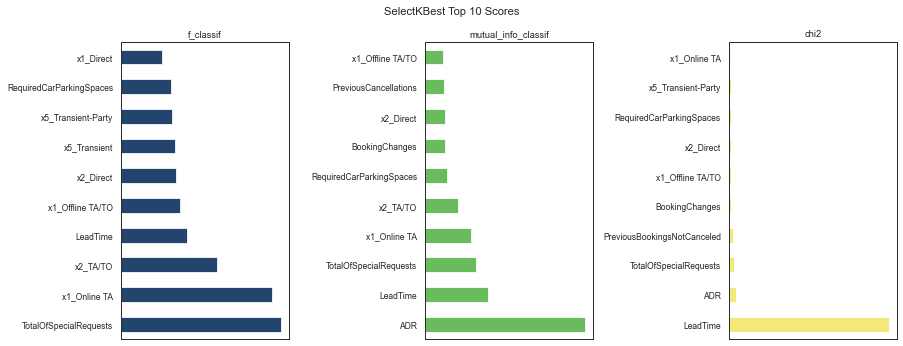

In [91]:
skb_test_funcs =       [f_classif, mutual_info_classif, chi2]
skb_test_func_labels = ['f_classif', 'mutual_info_classif', 'chi2']

all_feats = num_feats+cat_feat_ohe

fig, ax = plt.subplots(1,3, figsize=(13,5))

for t in range(len(skb_test_funcs)): 
    skb = SelectKBest(score_func=skb_test_funcs[t], k='all').fit(X_train[all_feats], y_train)
    
    s = [i for i in range(len(skb.scores_))]
    s_ = pd.DataFrame(skb.scores_, index=all_feats).sort_values(by=0, ascending=False)[0:10]
    s_.plot(kind='barh', ax=ax[t], color=CAT_COLORS[t])
    ax[t].set_title(skb_test_func_labels[t])
    ax[t].legend([], frameon=False)
    ax[t].set_xticks([])



fig.suptitle('SelectKBest Top 10 Scores')
plt.tight_layout()
plt.show()

In [92]:
variance_vals = pd.DataFrame(X_train.var(), columns=['var']).sort_values(by='var', ascending=False)
variance_vals.loc[variance_vals['var']>1]

,var
LeadTime,5548.651001
ADR,2318.194728
ArrivalDateWeekNumber,186.533469
DaysInWaitingList,181.370951
ArrivalDateDayOfMonth,78.377528
ArrivalDateMonthNumber,9.664260
ArrivalDayOfWeek,3.941740
StaysInWeekNights,2.645745
PreviousBookingsNotCanceled,2.527907


# Model Selection

Summary of variable names:

X_train
y_train

X_val
y_val

num_feats
cat_feats
cat_feat_ohe

all_feats

## Setup scoring

In [93]:
## Model scores on validation
scorefunc = 'f1'
model_scores = pd.DataFrame()
model_val = pd.DataFrame(index=[0])
split_scores = ['split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',]

In [94]:
fitted_models = []

In [95]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

## GradientBoostingClassifier

In [96]:
GB = GradientBoostingClassifier(random_state=RANDOM_STATE)

params = {
    'loss': ('deviance', 'exponential'), 
    'max_features': ('auto', 'sqrt', 'log2'), 
    'learning_rate': np.arange(0.1, 1, 0.1), 
    'n_estimators' : np.arange(100, 300, 50)
}

params_ = {
    'n_estimators': [150], 
    'max_features': ['log2'], 
    'loss': ['deviance'], 
    'learning_rate': [0.7000000000000001]
}
#0.7591252989286701

RSCV = RandomizedSearchCV(GB, param_distributions=params_,
                          scoring=scorefunc, n_jobs=-1, cv=10,
                          random_state=RANDOM_STATE, n_iter=10)

RSCV.fit(X_train[all_feats], y_train.values.ravel())

print(RSCV.best_params_)
print(RSCV.best_score_)

{'n_estimators': 150, 'max_features': 'log2', 'loss': 'deviance', 'learning_rate': 0.7000000000000001}
0.6036851319628543


In [97]:
fitted_models.append(('GradientBoostingClassifier', RSCV.best_estimator_))

In [98]:
scores_gbc = pd.DataFrame(RSCV.cv_results_).sort_values(by='rank_test_score')
print('Validation: ', RSCV.score(X_val[all_feats], y_val))
scores_gbc[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Validation:  0.7009844818955447

Validation:  0.565020455873758


,params,mean_test_score,std_test_score,rank_test_score
0,"{'n_estimators': 150, 'max_features': 'log2', ...",0.603685,0.093232,1


In [99]:
model_scores['GradientBoostingClassifier'] = scores_gbc[split_scores].T
model_val['GradientBoostingClassifier'] = RSCV.score(X_val[all_feats], y_val)

## MLPClassifier

In [100]:
pipe_nn = make_pipeline(StandardScaler(), 
                     SelectKBest(mutual_info_classif),
                     MLPClassifier(random_state=RANDOM_STATE, verbose=False, max_iter=400))

# putting together a parameter grid to search over using grid search

params_nn = {
    'selectkbest__k':[30],
    'mlpclassifier__hidden_layer_sizes': [(10,10,10,10)],
    'mlpclassifier__activation': ['identity']
}


gs_nn = RandomizedSearchCV(pipe_nn, param_distributions=params_nn,
                          scoring=scorefunc, n_jobs=-1, cv=10,
                          random_state=RANDOM_STATE, n_iter=10)
gs_nn.fit(X_train[all_feats], y_train.values.ravel())

gs_nn.best_params_

{'selectkbest__k': 30,
 'mlpclassifier__hidden_layer_sizes': (10, 10, 10, 10),
 'mlpclassifier__activation': 'identity'}

In [101]:
fitted_models.append(('MLPClassifier', gs_nn.best_estimator_))

In [102]:
scores_nn = pd.DataFrame(gs_nn.cv_results_).sort_values(by='rank_test_score')
print('Validation: ', gs_nn.score(X_val[all_feats], y_val))
scores_nn[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Validation:  0.7004787668833443

Validation:  0.5820693057097053


,params,mean_test_score,std_test_score,rank_test_score
0,"{'selectkbest__k': 30, 'mlpclassifier__hidden_...",0.689919,0.083613,1


In [103]:
model_scores['MLPClassifier'] = scores_nn[split_scores].T
model_val['MLPClassifier'] = gs_nn.score(X_val[all_feats], y_val)

## GaussianNaiveBayes

In [104]:
pipe_gnb = make_pipeline(MinMaxScaler(), 
                     SelectKBest(mutual_info_classif),
                     GaussianNB())

In [105]:
params_gnb = {
    'selectkbest__k':[5]
}

gs_gnb = RandomizedSearchCV(pipe_gnb,params_gnb,n_jobs=-1,cv=10, scoring=scorefunc)

gs_gnb.fit(X_train[all_feats], y_train.values.ravel())


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('selectkbest',
                                              SelectKBest(score_func=<function mutual_info_classif at 0x12786ca60>)),
                                             ('gaussiannb', GaussianNB())]),
                   n_jobs=-1, param_distributions={'selectkbest__k': [5]},
                   scoring='f1')

In [106]:
fitted_models.append(('GaussianNB', gs_gnb.best_estimator_))

In [107]:
scores_gnb = pd.DataFrame(gs_gnb.cv_results_).sort_values(by='rank_test_score')
print('Validation: ', gs_gnb.score(X_val[all_feats], y_val))
scores_gnb[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]


Validation:  0.5586102561427304


,params,mean_test_score,std_test_score,rank_test_score
0,{'selectkbest__k': 5},0.709496,0.07457,1


In [108]:
model_scores['GaussianNB'] = scores_gnb[split_scores].T
model_val['GaussianNB'] = gs_gnb.score(X_val[all_feats], y_val)

## Decision Trees

In [109]:
dtc_ = DecisionTreeClassifier(random_state=RANDOM_STATE, splitter='best',
 criterion='entropy',
 max_depth= 15,
 max_features= None,
 min_impurity_decrease= 0,
 min_samples_leaf= 1,
 min_samples_split= 11,
 min_weight_fraction_leaf= 0,
 ccp_alpha=0.00014
    )


params_dtc = {
}

#setting up the grid search
gs_dtc = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                     params_dtc,n_jobs=-1,cv=10, scoring=scorefunc)

#fitting gs to training data
gs_dtc.fit(X_train[all_feats], y_train.values.ravel())


print(gs_dtc.best_params_)
print(gs_dtc.best_score_)

{}
0.5797913422886608


In [110]:
fitted_models.append(('DecisionTreeClassifier', gs_dtc.best_estimator_))

In [111]:
scores_dtc = pd.DataFrame(gs_dtc.cv_results_).sort_values(by='rank_test_score')
print('Validation: ', gs_dtc.score(X_val[all_feats], y_val))
scores_dtc[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]


Validation:  0.5044361666102269


,params,mean_test_score,std_test_score,rank_test_score
0,{},0.579791,0.123958,1


In [112]:
model_scores['DecisionTreeClassifier'] = scores_dtc[split_scores].T
model_val['DecisionTreeClassifier'] = gs_dtc.score(X_val[all_feats], y_val)

## RandomForestClassifier

In [113]:
from sklearn.ensemble import RandomForestClassifier


In [114]:
params_rf = {
    'criterion': ['gini'],
    'n_estimators':[81],
    'max_depth': [None],
    'min_samples_split':[6],
    'ccp_alpha':[0.00002]
}

#setting up the grid search
gs_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                     params_rf,n_jobs=-1,cv=10, scoring=scorefunc)

#fitting gs to training data
gs_rf.fit(X_train[all_feats], y_train.values.ravel())


print(gs_rf.best_params_)
print(gs_rf.best_score_)

{'ccp_alpha': 2e-05, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 6, 'n_estimators': 81}
0.6342734816773775


In [115]:
fitted_models.append(('RandomForestClassifier', gs_rf.best_estimator_))

In [116]:
scores_rfc = pd.DataFrame(gs_rf.cv_results_).sort_values(by='rank_test_score')
print('Validation: ', gs_rf.score(X_val[all_feats], y_val))
scores_rfc[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]


Validation:  0.5578774360178447


,params,mean_test_score,std_test_score,rank_test_score
0,"{'ccp_alpha': 2e-05, 'criterion': 'gini', 'max...",0.634273,0.145659,1


In [117]:
model_scores['RandomForestClassifier'] = scores_rfc[split_scores].T
model_val['RandomForestClassifier'] = gs_rf.score(X_val[all_feats], y_val)

## KNearestNeighbors

In [118]:
pipe_knn = make_pipeline(MinMaxScaler(), 
                     KNeighborsClassifier())
params_knn = {
    'kneighborsclassifier__metric': ['manhattan'], 
    'kneighborsclassifier__n_neighbors': [10], 
    'kneighborsclassifier__weights': ['uniform']
}

gs_knn = GridSearchCV(pipe_knn,
                     params_knn,n_jobs=-1,cv=10, scoring=scorefunc)


gs_knn.fit(X_train[all_feats], y_train.values.ravel())


print(gs_knn.best_params_)
print(gs_knn.best_score_)

{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}
0.6355819676954096


In [119]:
fitted_models.append(('KNeighborsClassifier', gs_knn.best_estimator_))

In [120]:
scores_knn = pd.DataFrame(gs_knn.cv_results_).sort_values(by='rank_test_score')
print('Validation: ', gs_knn.score(X_val[all_feats], y_val))
scores_knn[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]


Validation:  0.4842273819055244


,params,mean_test_score,std_test_score,rank_test_score
0,"{'kneighborsclassifier__metric': 'manhattan', ...",0.635582,0.158861,1


In [121]:
model_scores['KNeighborsClassifier'] = scores_knn[split_scores].T
model_val['KNeighborsClassifier'] = gs_knn.score(X_val[all_feats], y_val)

## LogisticRegression

In [122]:
pipe_log = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=400, random_state=RANDOM_STATE))



params_log = {
    'logisticregression__C': [10.0],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['saga']
}

#setting up the grid search, use pipe
gs_log = GridSearchCV(pipe_log,
                     params_log,n_jobs=-1,cv=10, 
                     scoring=scorefunc)

#fitting gs to training data
gs_log.fit(X_train[all_feats], y_train.values.ravel())





scores_log = pd.DataFrame(gs_log.cv_results_).sort_values(by='rank_test_score')
print('Validation: ', gs_log.score(X_val[all_feats], y_val))
scores_log[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

Validation:  0.5799430559949382


,params,mean_test_score,std_test_score,rank_test_score
0,"{'logisticregression__C': 10.0, 'logisticregre...",0.689887,0.090939,1


In [123]:
fitted_models.append(('LogisticRegression', gs_log.best_estimator_))

In [124]:
model_scores['LogisticRegression'] = scores_log[split_scores].T
model_val['LogisticRegression'] = gs_log.score(X_val[all_feats], y_val)

## VotingClassifier

In [125]:
from sklearn.ensemble import VotingClassifier


In [126]:
#vote_estimators = [(m,final_models[m][0]) for m in final_models]
#vote_estimators
vote_estimators_default = [
    ('DT',DecisionTreeClassifier()),
    ('LR',LogisticRegression(max_iter=400)),
    ('GNB',GaussianNB()),
    ('NN',MLPClassifier(max_iter=400)),
    ('RF',RandomForestClassifier()),
    ('KN',KNeighborsClassifier()),
    ('GRB',GradientBoostingClassifier())
]

vote = VotingClassifier(estimators=vote_estimators_default,voting='soft')

pipe_vote = make_pipeline(vote)

gs_vote = GridSearchCV(pipe_vote,
                     {},n_jobs=-1,cv=10, 
                     scoring=scorefunc)

gs_vote.fit(X_train[all_feats], y_train.values.ravel())


/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('votingclassifier',
                                        VotingClassifier(estimators=[('DT',
                                                                      DecisionTreeClassifier()),
                                                                     ('LR',
                                                                      LogisticRegression(max_iter=400)),
                                                                     ('GNB',
                                                                      GaussianNB()),
                                                                     ('NN',
                                                                      MLPClassifier(max_iter=400)),
                                                                     ('RF',
                                                                      RandomForestClassifier()),
                                                       

In [127]:
scores_vote = pd.DataFrame(gs_vote.cv_results_).sort_values(by='rank_test_score')
print('Validation: ', gs_vote.score(X_val[all_feats], y_val))
scores_vote[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

Validation:  0.5740624345275508


,params,mean_test_score,std_test_score,rank_test_score
0,{},0.654365,0.092857,1


In [128]:
model_scores['VotingClassifier'] = scores_vote[split_scores].T
model_val['VotingClassifier'] = gs_vote.score(X_val[all_feats], y_val)

### Fitted models

In [129]:
vote = VotingClassifier(estimators=fitted_models,voting='soft')

pipe_vote = make_pipeline(vote)

gs_vote_fitted = GridSearchCV(pipe_vote,
                     {},n_jobs=-1,cv=10, 
                     scoring=scorefunc)

gs_vote_fitted.fit(X_train[all_feats], y_train.values.ravel())


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('votingclassifier',
                                        VotingClassifier(estimators=[('GradientBoostingClassifier',
                                                                      GradientBoostingClassifier(learning_rate=0.7000000000000001,
                                                                                                 max_features='log2',
                                                                                                 n_estimators=150,
                                                                                                 random_state=9)),
                                                                     ('MLPClassifier',
                                                                      Pipeline(steps=[('standardscaler',
                                                                                       StandardScaler()),
                                           

In [130]:
scores_vote_fitted = pd.DataFrame(gs_vote_fitted.cv_results_).sort_values(by='rank_test_score')
print('Validation: ', gs_vote_fitted.score(X_val[all_feats], y_val))
scores_vote_fitted[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

Validation:  0.579581483830057


,params,mean_test_score,std_test_score,rank_test_score
0,{},0.644879,0.113299,1


In [131]:
model_scores['VotingClassifierFitted'] = scores_vote_fitted[split_scores].T
model_val['VotingClassifierFitted'] = gs_vote_fitted.score(X_val[all_feats], y_val)

## Final Scores

In [132]:
model_scores

,GradientBoostingClassifier,MLPClassifier,GaussianNB,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,VotingClassifier,VotingClassifierFitted
split0_test_score,0.529326,0.566558,0.625754,0.550449,0.557364,0.476637,0.550505,0.602673,0.554226
split1_test_score,0.520450,0.643734,0.768028,0.402230,0.417586,0.390747,0.595064,0.558113,0.484458
split2_test_score,0.447924,0.575799,0.698737,0.351288,0.383900,0.401904,0.594223,0.477699,0.482347
split3_test_score,0.474135,0.585408,0.522617,0.458318,0.508113,0.517406,0.588674,0.549736,0.514676
split4_test_score,0.658755,0.740132,0.732136,0.693355,0.770247,0.777048,0.748605,0.719899,0.741611
split5_test_score,0.674259,0.804981,0.761045,0.693230,0.786346,0.793140,0.813344,0.752631,0.764736
split6_test_score,0.680324,0.741930,0.722932,0.682289,0.747245,0.776770,0.744623,0.728424,0.735284
split7_test_score,0.694347,0.763221,0.735522,0.667795,0.747177,0.761580,0.775107,0.731739,0.739847
split8_test_score,0.684534,0.741324,0.755777,0.666359,0.738526,0.729163,0.743289,0.721587,0.721703
split9_test_score,0.672798,0.736101,0.772416,0.632600,0.686230,0.731423,0.745435,0.701144,0.709899


In [133]:
model_val

,GradientBoostingClassifier,MLPClassifier,GaussianNB,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,VotingClassifier,VotingClassifierFitted
0,0.56502,0.582069,0.55861,0.504436,0.557877,0.484227,0.579943,0.574062,0.579581


In [134]:
model_val_t = pd.DataFrame()
model_val_t['Scores'] = model_val.T[0]
model_val_t

,Scores
GradientBoostingClassifier,0.565020
MLPClassifier,0.582069
GaussianNB,0.558610
DecisionTreeClassifier,0.504436
RandomForestClassifier,0.557877
KNeighborsClassifier,0.484227
LogisticRegression,0.579943
VotingClassifier,0.574062
VotingClassifierFitted,0.579581


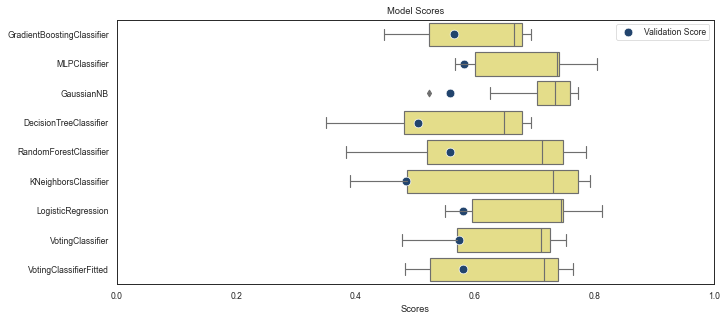

In [137]:
fig, ax = plt.subplots(figsize=(11,5))
ax.set_title('Model Scores')

sns.boxplot(data=model_scores, orient='h', color=CAT_COLORS[2])
sns.scatterplot(data=model_val_t, y=model_val_t.index, x='Scores', s=80, color=CAT_COLORS[0], label='Validation Score')
ax.set_xlim(0,1)
plt.show()